# architecture-28-111 ( Basic Classification ) zig-zag

## What's new:

1- Without RSI

2- add labels only start and end of trends.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import talib


In [5]:
# 1- Load and Scaling Features
# Load and preprocess
df = pd.read_csv('datasets-28-111/XAGUSD-H1-rates.csv', sep='\t')

# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# Optional: Combine DATE and TIME into a single datetime column
df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])

# Drop rows with missing values
df.dropna(inplace=True)

# Sort data chronologically by DATETIME
df.sort_values(by='DATETIME', inplace=True)

# Reset index to ensure clean row order
df.reset_index(drop=True, inplace=True)

# Select features to scale
features = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [7]:
# 2- ZigZag-like reversal labeling using TA-Lib MINMAX
def talib_reversal_labels(high, low, close, lookback=10, deviation=0.02):
    """
    Detect trend reversals using TA-Lib MIN/MAX logic (ZigZag-like).
    Returns: labels (0 = no signal, 1 = buy valley, 2 = sell peak)
    """
    labels = np.zeros(len(close), dtype=int)

    # Rolling highs and lows
    rolling_max = talib.MAX(high, timeperiod=lookback)
    rolling_min = talib.MIN(low, timeperiod=lookback)

    for i in range(lookback, len(close)):
        # Peak detection (sell signal)
        if high[i] >= rolling_max[i] and (high[i] - rolling_min[i]) / rolling_min[i] > deviation:
            labels[i] = 2  # Sell at peak

        # Valley detection (buy signal)
        elif low[i] <= rolling_min[i] and (rolling_max[i] - low[i]) / rolling_max[i] > deviation:
            labels[i] = 1  # Buy at valley

    return labels

# Apply function
df['Label'] = talib_reversal_labels(df['HIGH'].values,
                                    df['LOW'].values,
                                    df['CLOSE'].values,
                                    lookback=12,   # similar to DEPTH
                                    deviation=0.02)  # % move like ZigZag

print(df[['DATE', 'TIME', 'CLOSE', 'Label']].tail(20))


             DATE      TIME   CLOSE  Label
55063  2024.05.02  04:00:00  26.716      0
55064  2024.05.02  05:00:00  26.629      0
55065  2024.05.02  06:00:00  26.558      0
55066  2024.05.02  07:00:00  26.554      0
55067  2024.05.02  08:00:00  26.517      0
55068  2024.05.02  09:00:00  26.538      0
55069  2024.05.02  10:00:00  26.448      0
55070  2024.05.02  11:00:00  26.405      0
55071  2024.05.02  12:00:00  26.362      0
55072  2024.05.02  13:00:00  26.225      1
55073  2024.05.02  14:00:00  26.290      0
55074  2024.05.02  15:00:00  26.080      1
55075  2024.05.02  16:00:00  26.302      1
55076  2024.05.02  17:00:00  26.705      2
55077  2024.05.02  18:00:00  26.513      0
55078  2024.05.02  19:00:00  26.566      0
55079  2024.05.02  20:00:00  26.674      0
55080  2024.05.02  21:00:00  26.703      0
55081  2024.05.02  22:00:00  26.650      0
55082  2024.05.02  23:00:00  26.646      0


In [9]:
def plot_labeled_candles(df, n=150):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    """
    # Use only the last n rows
    df_plot = df.tail(n).copy()
    df_plot['DATETIME'] = df_plot['DATE'] + ' ' + df_plot['TIME']

    # Plot the closing price
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # Plot BUY (label=1) and SELL (label=2) signals
    for idx, row in df_plot.iterrows():
        if row['Label'] == 1:
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()

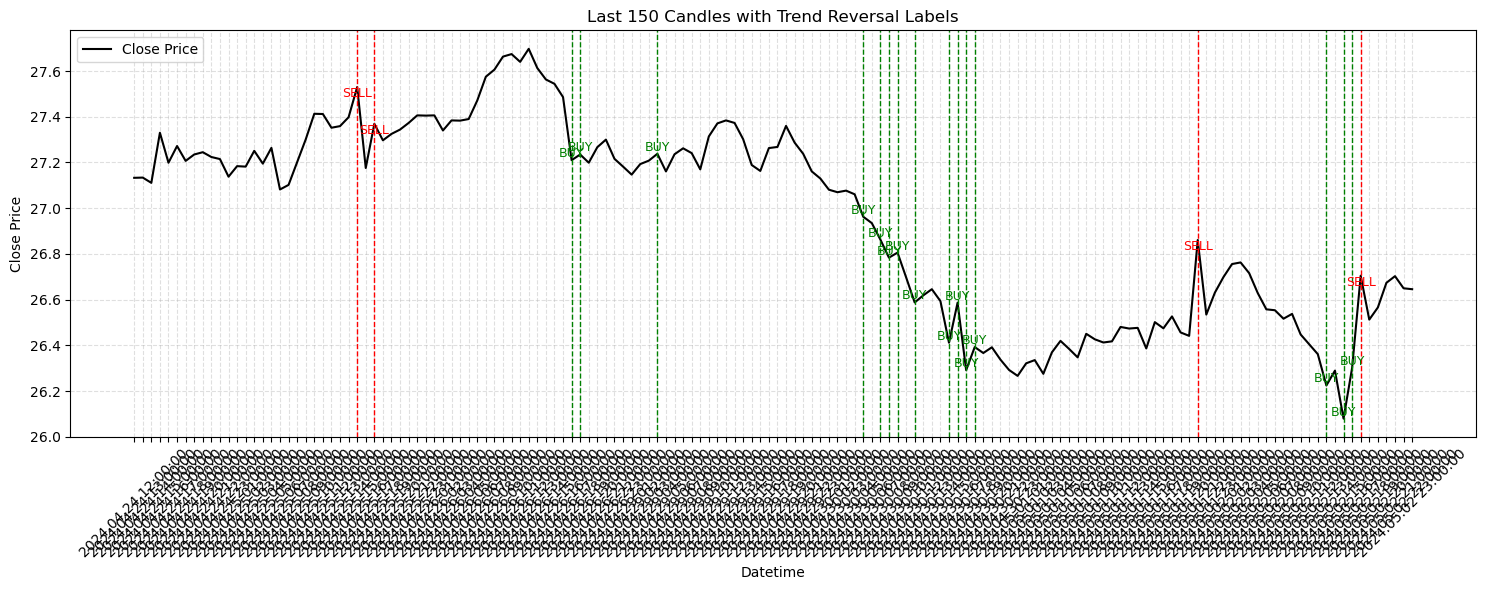

In [10]:
plot_labeled_candles(df)

# plot section